# DIAGNOSTIC ANALYTICS: CUSTOMER CHURN DATA

## 0) Import Python modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import dash
# import dash_core_components as dcc
from dash import html, dcc
import dash_bootstrap_components as dbc
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## 1) Data collection

In [5]:
df = pd.read_excel("data/Customer_Churn_Dataset.xlsx")

## 2) Data understanding and pre-processing

Basic dataset **information**:

In [8]:
df.info()
print(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


Total charges are not in numerical data, and we know from metadata that for senior citizen 0 = No and 1 = Yes, so we transform them:

In [10]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [11]:
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

Are there any **duplicated** or **null values**?

In [13]:
print("Number of duplicated values: ",df.duplicated().sum())
print("\nNull values: ")
df.isnull().sum()

Number of duplicated values:  0

Null values: 


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
numAdminTickets      0
numTechTickets       0
Churn                0
dtype: int64

In [14]:
df[df["TotalCharges"].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
488,4472-LVYGI,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0,No
753,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,5,0,No
936,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0,0,No
1082,4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,1,0,No
1340,1371-DWPAZ,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0,0,No
3331,7644-OMVMY,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0,0,No
3826,3213-VVOLG,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0,0,No
4380,2520-SGTTA,Female,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,5,0,No
5218,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0,0,No
6670,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,No,Two year,No,Mailed check,73.35,NaN,0,0,No


We have no clue on how to fill these total charges that are missing, so we will drop these rows:

In [16]:
df.dropna(subset=['TotalCharges'], inplace=True)

In [17]:
# Summary statistics for numerical columns
numerical_summary = df.describe()
print(numerical_summary)

# Summary statistics for categorical columns
categorical_summary = df.describe(include=['object'])
print(categorical_summary)

            tenure  MonthlyCharges  TotalCharges  numAdminTickets  \
count  7032.000000     7032.000000   7032.000000      7032.000000   
mean     32.421786       64.798208   2283.300441         0.514932   
std      24.545260       30.085974   2266.771362         1.273921   
min       1.000000       18.250000     18.800000         0.000000   
25%       9.000000       35.587500    401.450000         0.000000   
50%      29.000000       70.350000   1397.475000         0.000000   
75%      55.000000       89.862500   3794.737500         0.000000   
max      72.000000      118.750000   8684.800000         5.000000   

       numTechTickets  
count     7032.000000  
mean         0.420222  
std          1.250984  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          9.000000  
        customerID gender SeniorCitizen Partner Dependents PhoneService  \
count         7032   7032          7032    7032       7032         7032   
unique      

## 3) Target variable analysis

Let’s start by understanding the distribution of Churn:

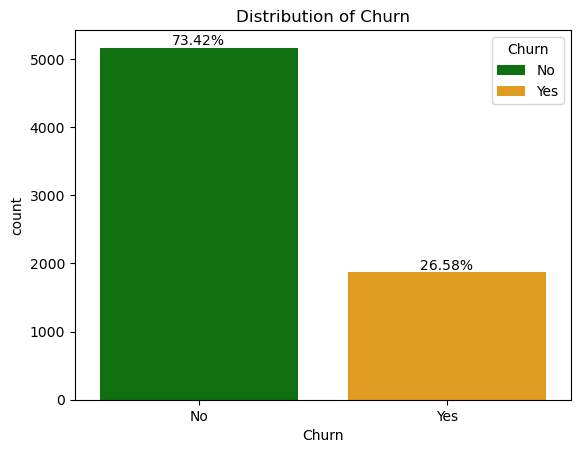

Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


In [20]:
# Distribution of the churn variable
colors1= ['Green', 'Orange']
ax = sns.countplot(x='Churn', palette=colors1, data=df, hue='Churn', legend=True)

# Calculate the percentage of each value
total_count = len(df)
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Avoid annotating empty bars
        ax.annotate(f'{height/total_count:.2%}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')

plt.title('Distribution of Churn')
plt.show()

# Churn rate
churn_rate = df['Churn'].value_counts(normalize=True) * 100
print(churn_rate)


We observe that **1 in every 4 customers were lost** in that month. This is a huge problem, so we need to identify variables that can be related to this phenomena:

## 4) Visualizations and statistical tests 

Let's dive deeper to explore churn across different **categorical variables**:

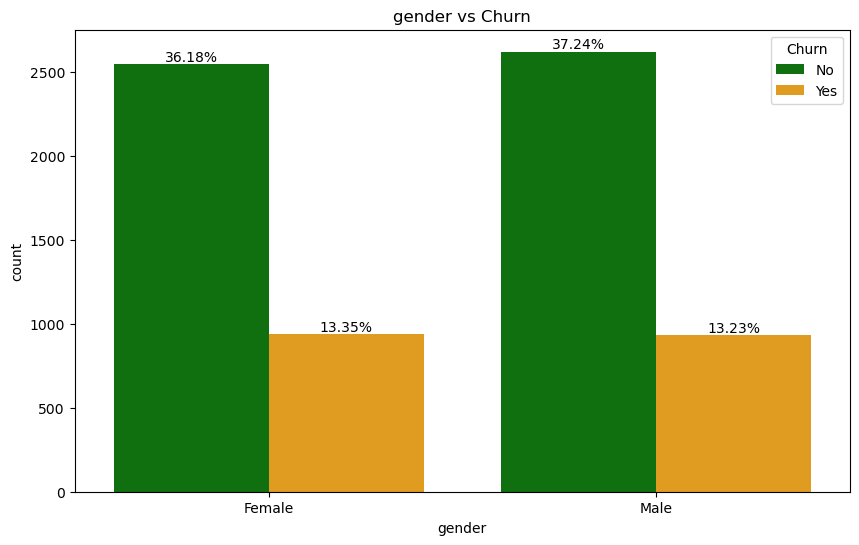

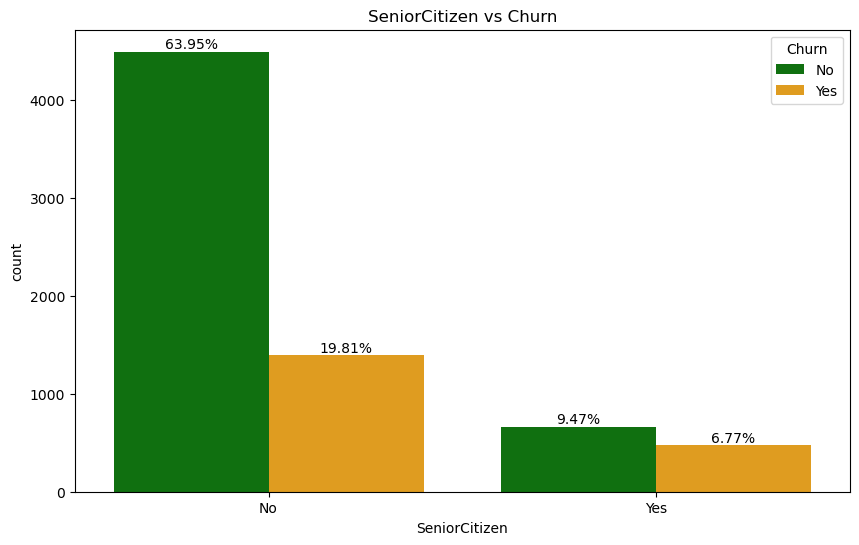

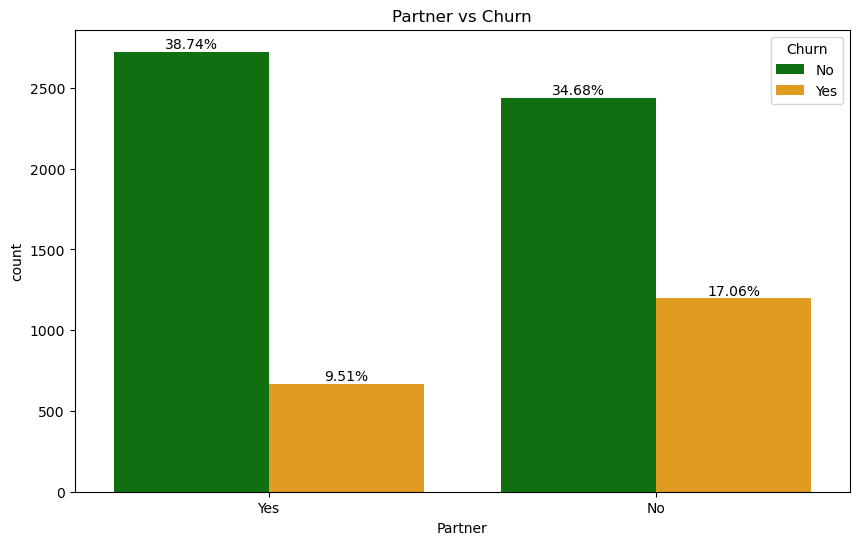

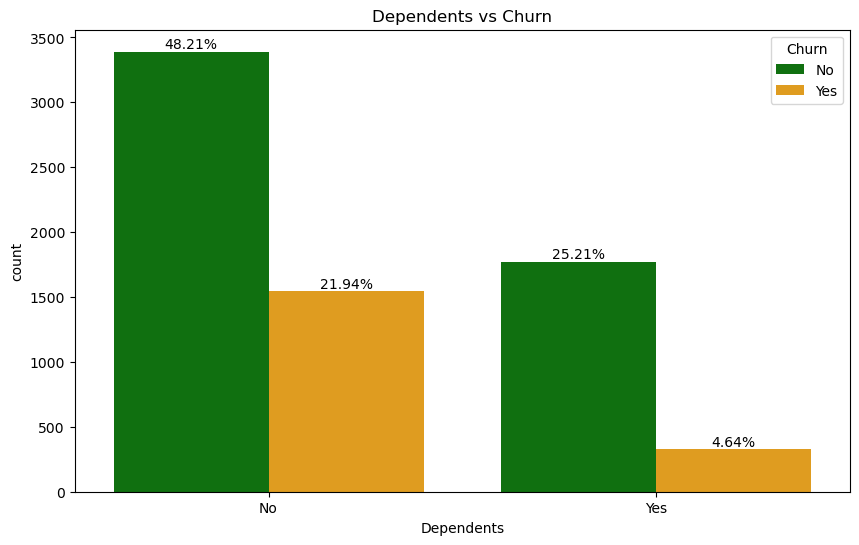

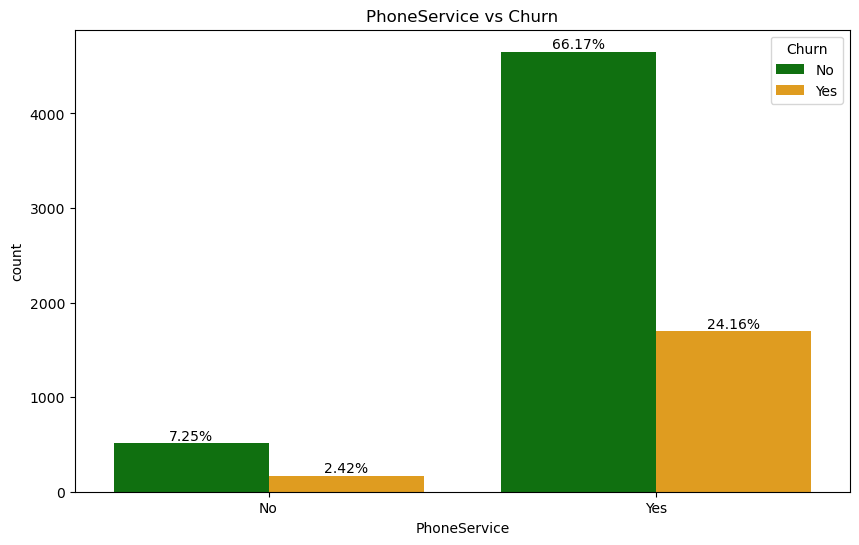

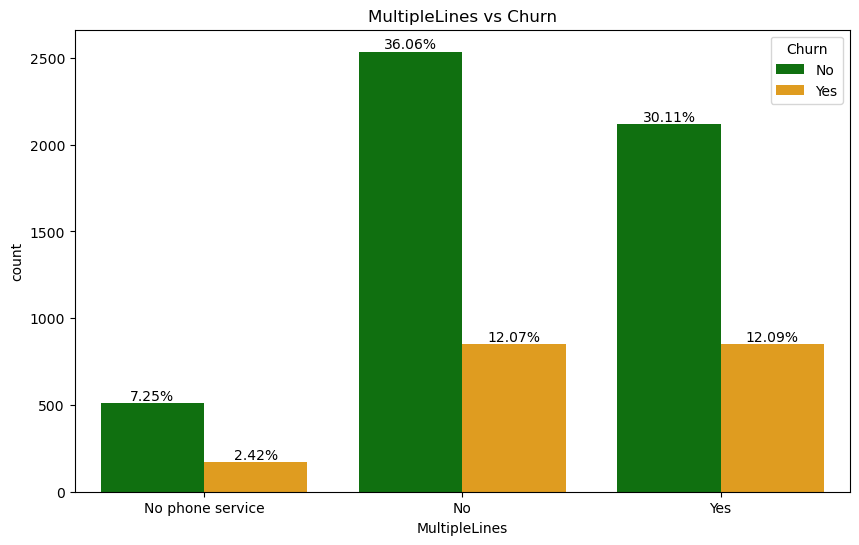

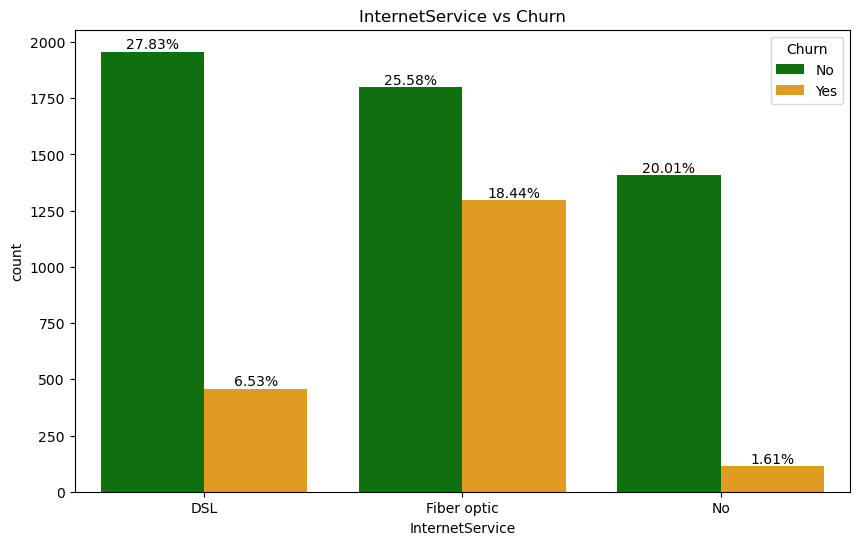

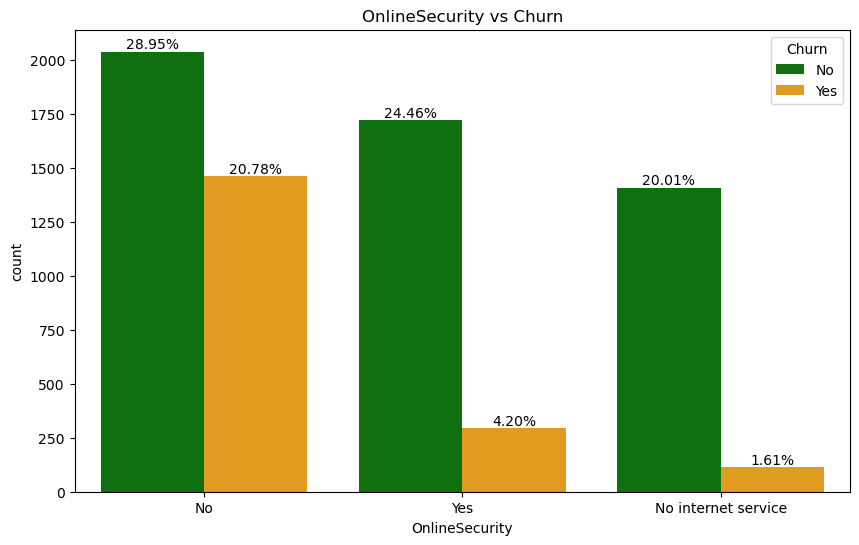

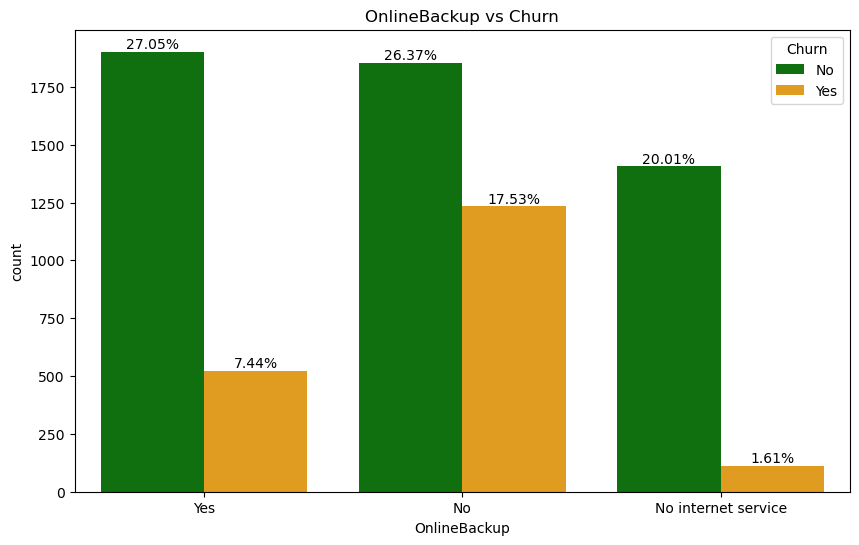

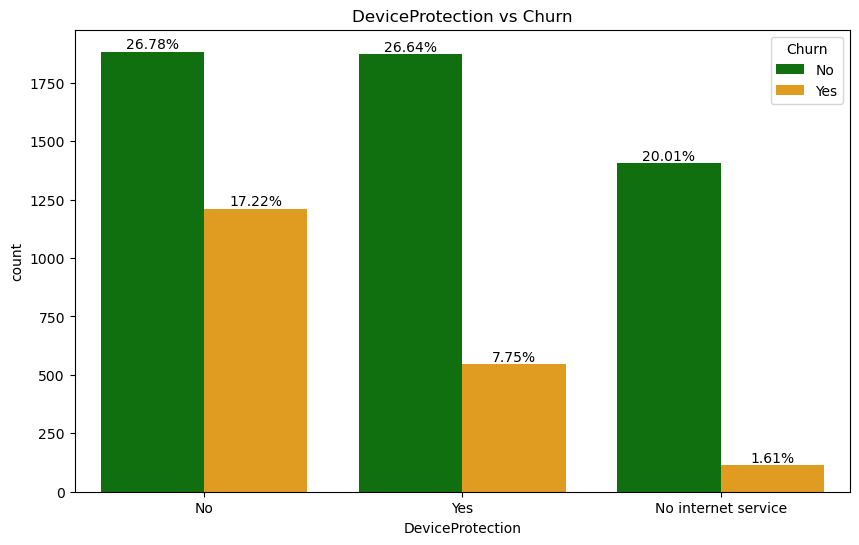

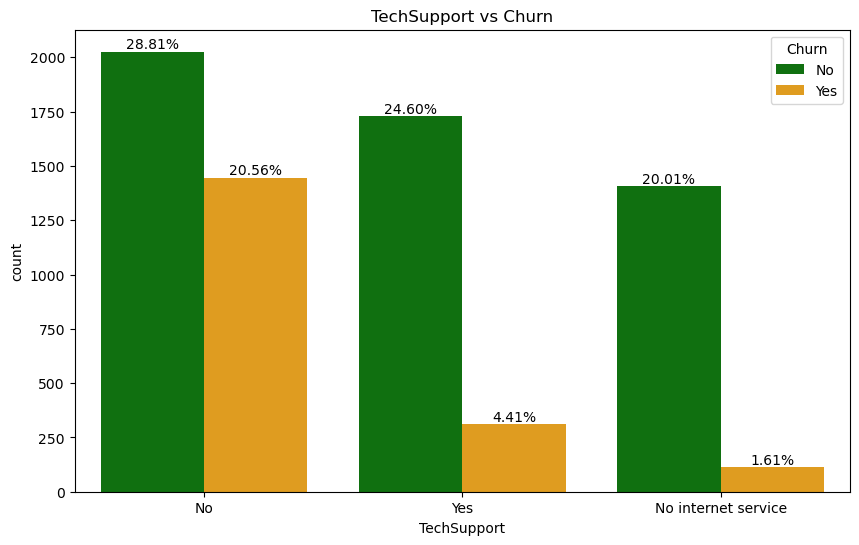

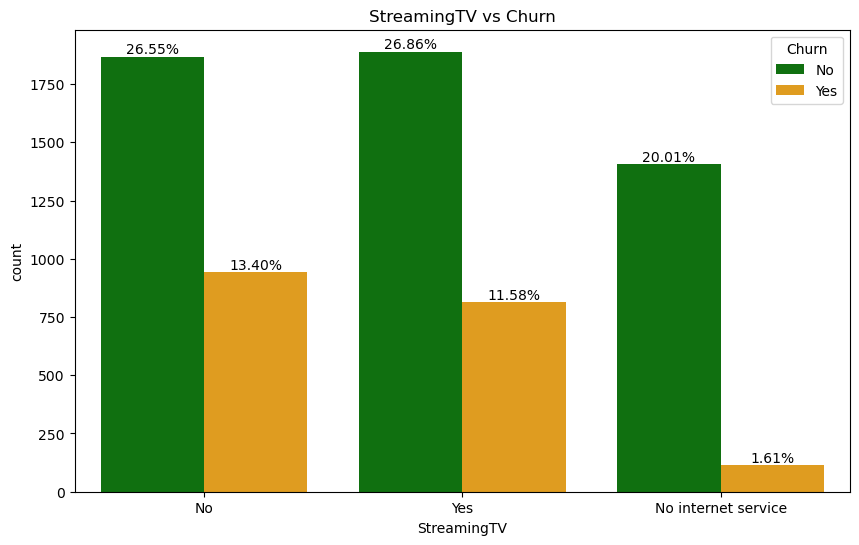

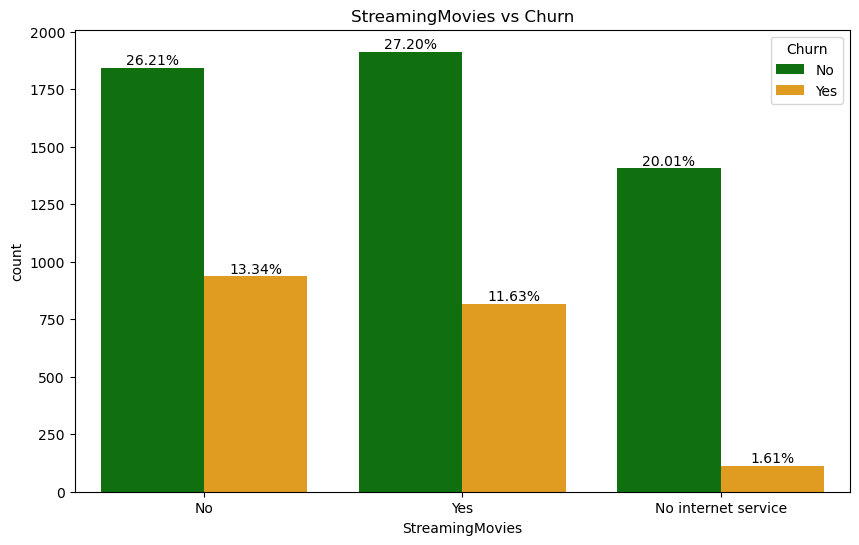

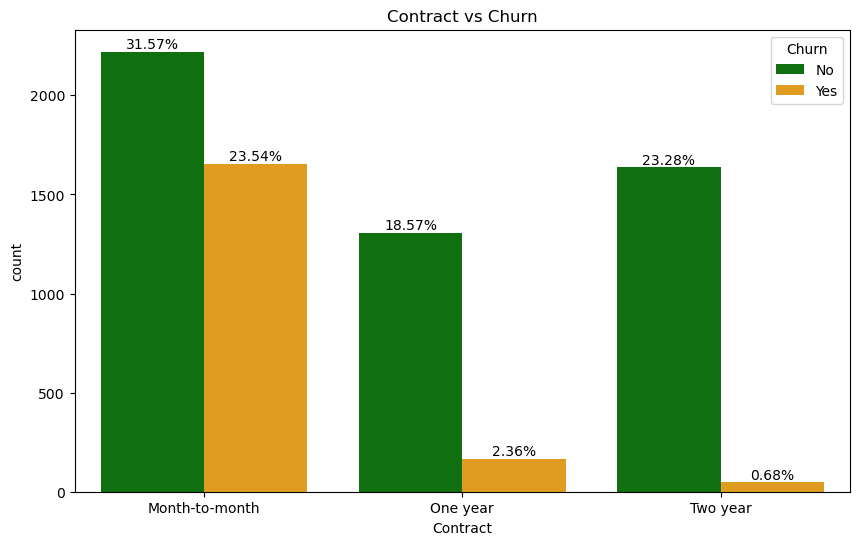

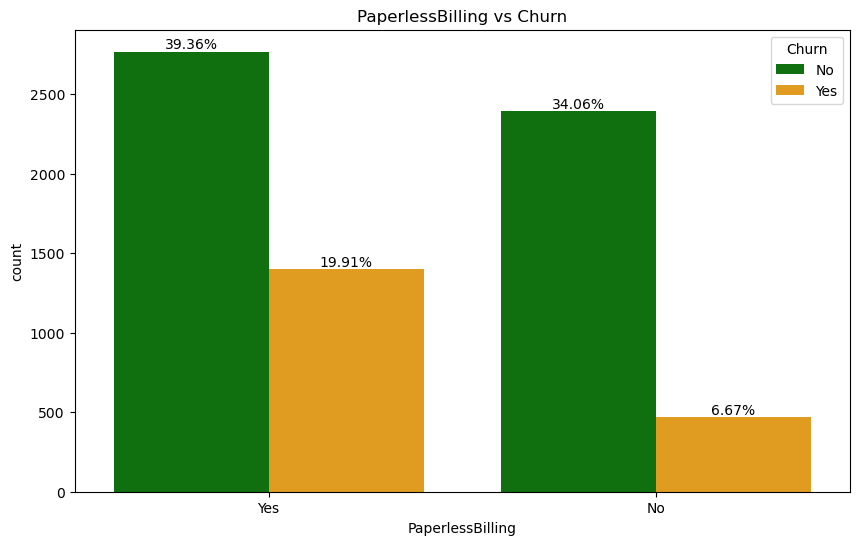

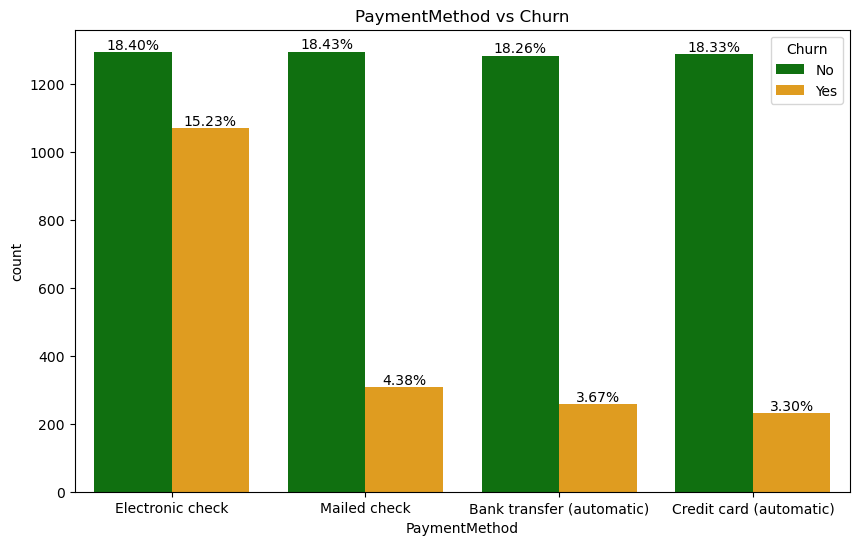

Chi-square test for gender: p-value = 0.4904884707065509
Bonferroni corrected p-value = 7.847815531304814
Result for gender is not significant after Bonferroni correction.


Chi-square test for SeniorCitizen: p-value = 2.4792557203954705e-36
Bonferroni corrected p-value = 3.9668091526327527e-35
Result for SeniorCitizen is significant after Bonferroni correction.


Chi-square test for Partner: p-value = 3.97379757451591e-36
Bonferroni corrected p-value = 6.358076119225456e-35
Result for Partner is significant after Bonferroni correction.


Chi-square test for Dependents: p-value = 2.0196592017051303e-42
Bonferroni corrected p-value = 3.2314547227282085e-41
Result for Dependents is significant after Bonferroni correction.


Chi-square test for PhoneService: p-value = 0.34992398942431924
Bonferroni corrected p-value = 5.598783830789108
Result for PhoneService is not significant after Bonferroni correction.


Chi-square test for MultipleLines: p-value = 0.0035679273999811405
Bonferroni cor

In [24]:
# List of categorical variables
categorical_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=var, hue='Churn', palette=colors1, data=df, legend=True)
    # Calculate the percentage of each value
    total_count = len(df)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Avoid annotating empty bars
            ax.annotate(f'{height/total_count:.2%}', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom')
    plt.title(f'{var} vs Churn')
    plt.show()
    
# Number of tests
num_tests = len(categorical_vars)
alpha = 0.05  # Desired significance level
bonferroni_alpha = alpha / num_tests  # Adjusted significance level

# Chi-square tests with Bonferroni correction (as we are doing multiple tests)
for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['Churn'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f'Chi-square test for {var}: p-value = {p}')
    print(f'Bonferroni corrected p-value = {p * num_tests}')
    if p < bonferroni_alpha:
        print(f'Result for {var} is significant after Bonferroni correction.')
        print('\n')
    else:
        print(f'Result for {var} is not significant after Bonferroni correction.')
        print('\n')


#### <u>Insights from Categorical Variables and Churn:</u>
- **Gender** does not appear to influence churn significantly (statistical test results were non-significant). However, **Senior citizens** seem to be more likely to churn.
- Customers without **Partners or Dependents** have a higher churn rate.
- **Phone service** and **Multiple lines** do not seem to be linked to churn (results were not significant).
- Customers with more advanced **Internet service** (Fiber > DSL > No Internet) appear more likely to churn.
- Contracts lacking **Online security, Online backup, Device protection, or Tech support** seem to have a higher churn rate.
- Customers with longer **Contract** terms appear less prone to churn.
- Customers with more modern **Billing** and **Payment** options seem more likely to churn.

Now let's focus on **numerical variables**:

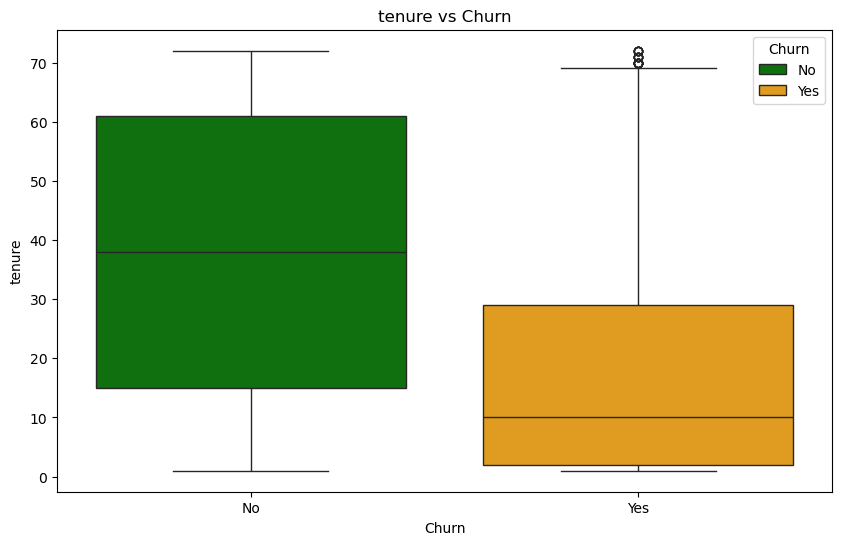

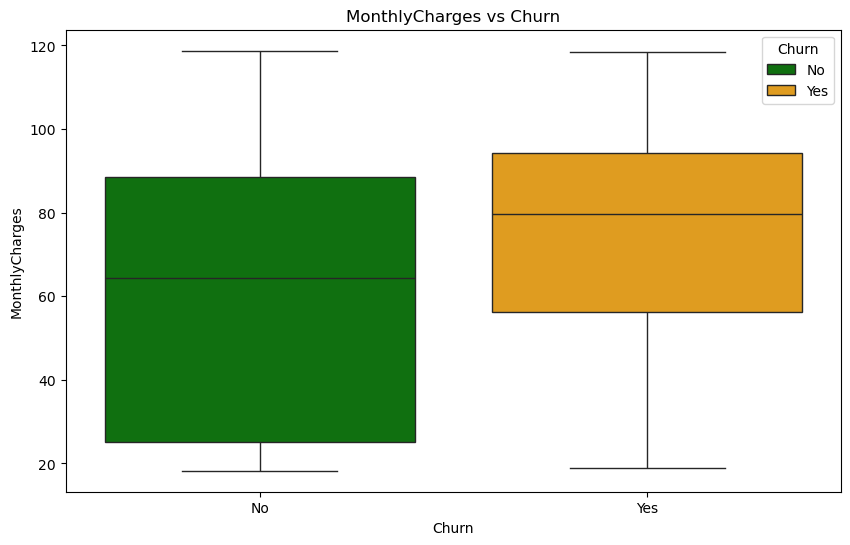

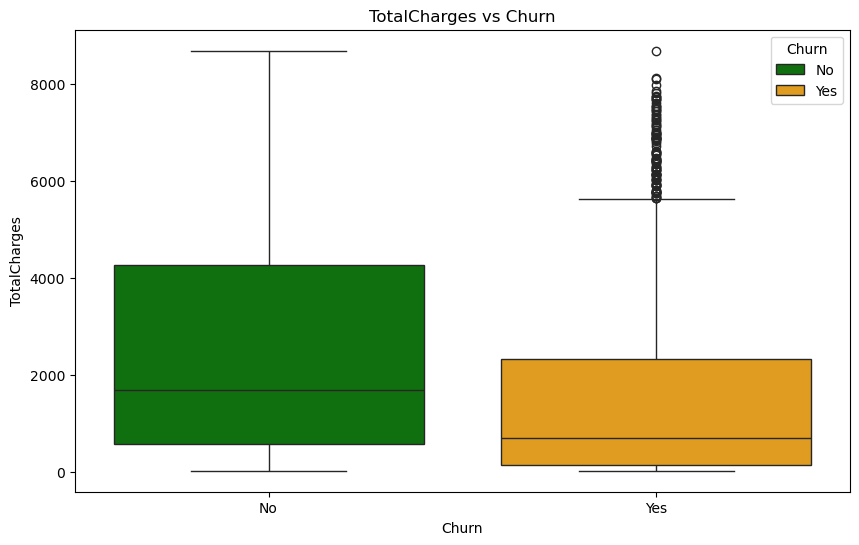

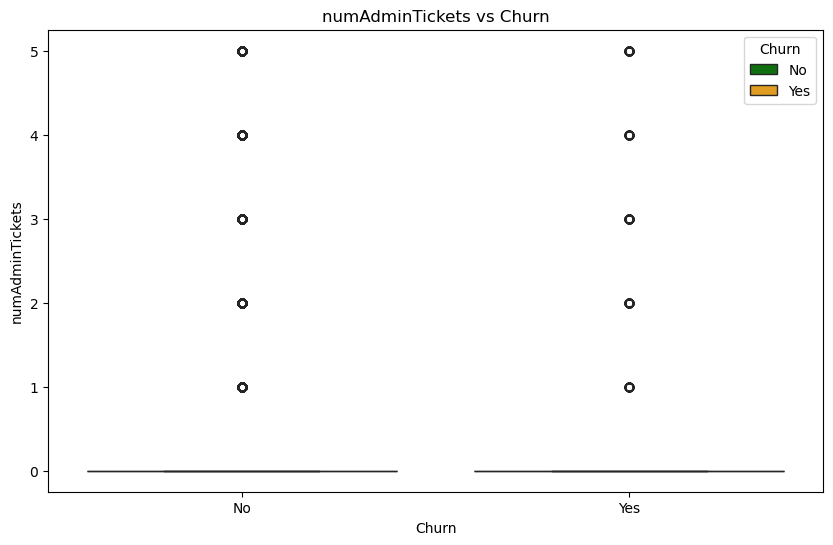

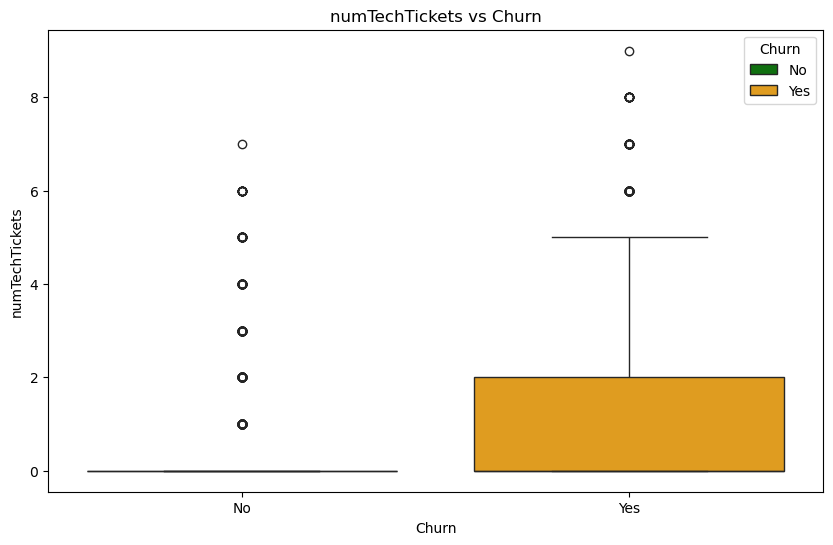

Mann-Whitney U test for tenure: U-statistic = 2494979.0000, p-value = 0.0000
Mann-Whitney U test for MonthlyCharges: U-statistic = 5986148.5000, p-value = 0.0000
Mann-Whitney U test for TotalCharges: U-statistic = 3360665.0000, p-value = 0.0000
Mann-Whitney U test for numAdminTickets: U-statistic = 4721334.0000, p-value = 0.0356
Mann-Whitney U test for numTechTickets: U-statistic = 6300667.0000, p-value = 0.0000

Bonferroni corrected significance level = 0.0100
tenure - Uncorrected p-value: 0.0000, Corrected p-value: 0.0000
Result for tenure is significant after Bonferroni correction.


MonthlyCharges - Uncorrected p-value: 0.0000, Corrected p-value: 0.0000
Result for MonthlyCharges is significant after Bonferroni correction.


TotalCharges - Uncorrected p-value: 0.0000, Corrected p-value: 0.0000
Result for TotalCharges is significant after Bonferroni correction.


numAdminTickets - Uncorrected p-value: 0.0356, Corrected p-value: 0.1779
Result for numAdminTickets is not significant aft

In [27]:
# List of numerical variables
numerical_vars = ['tenure', 'MonthlyCharges', 'TotalCharges', 'numAdminTickets', 'numTechTickets']

# Boxplot for numerical variables
for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Churn', y=var, palette=colors1, hue='Churn', legend=True, data=df)
    plt.title(f'{var} vs Churn')
    plt.show()


# Statistical test results
results = []

for var in numerical_vars:
    churned = df[df['Churn'] == 'Yes'][var].dropna()
    not_churned = df[df['Churn'] == 'No'][var].dropna()
    
    # Perform Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(churned, not_churned, alternative='two-sided')
    results.append((var, u_stat, p_val))
    print(f'Mann-Whitney U test for {var}: U-statistic = {u_stat:.4f}, p-value = {p_val:.4f}')

# Apply Bonferroni correction
num_tests = len(numerical_vars)
alpha = 0.05
bonferroni_alpha = alpha / num_tests

print(f'\nBonferroni corrected significance level = {bonferroni_alpha:.4f}')

for var, u_stat, p_val in results:
    corrected_p_val = min(p_val * num_tests, 1.0)  # Ensure p-value does not exceed 1
    print(f'{var} - Uncorrected p-value: {p_val:.4f}, Corrected p-value: {corrected_p_val:.4f}')
    if corrected_p_val < bonferroni_alpha:
        print(f'Result for {var} is significant after Bonferroni correction.')
        print('\n')
    else:
        print(f'Result for {var} is not significant after Bonferroni correction.')
        print('\n')


#### <u>Insights from Numerical Variables and Churn:</u>
- Lower **Tenure** appears to be associated with an increased likelihood of churn.
- Higher **Mothly charges** seem to be linked with customer churn, whereas **Total charges** also show a similar trend with lower values being associated with churn.
- A higher number of **Tech tickets** appears to be related to an increased likelihood of churn, while the number of **Admin tickets** does not seem to have a significant effect.

## 5) High-risk customer segments

We will do a **segmentation analysis** to find out which are the high-risk customer for churn.

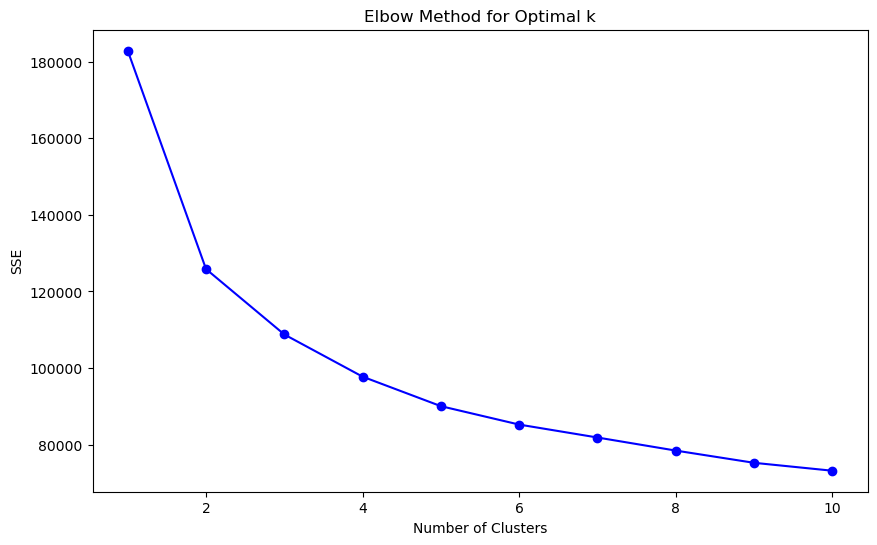

Churn          No       Yes
Segment                    
0        0.878241  0.121759
1        0.688377  0.311623
2        0.993532  0.006468
3        0.541993  0.458007
4        0.921405  0.078595
5        0.462528  0.537472
6        0.214493  0.785507
7        0.994863  0.005137
8        0.992101  0.007899


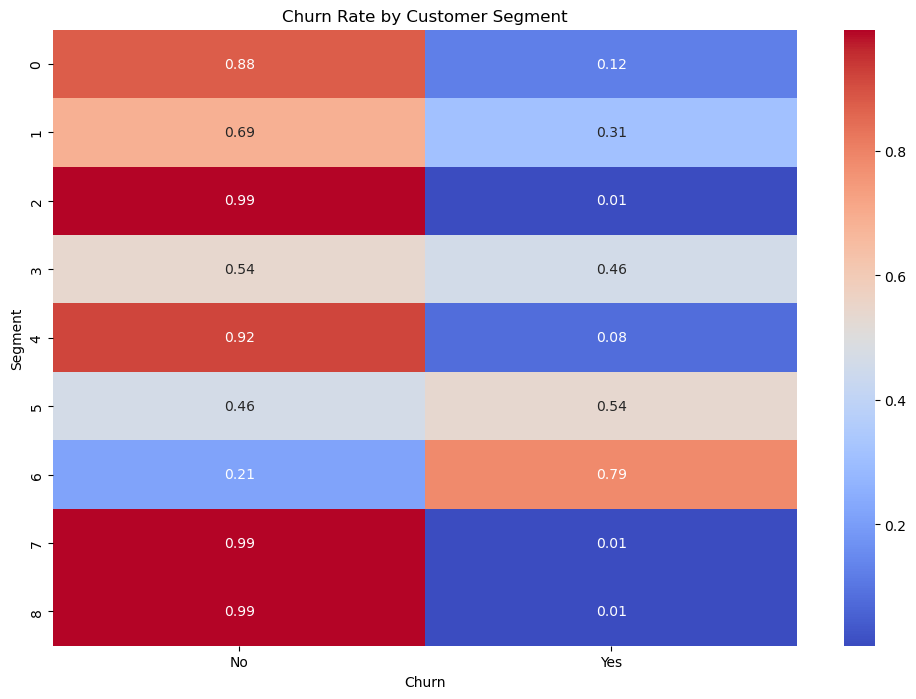

In [31]:
# Select features for clustering
features = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'numTechTickets', 'SeniorCitizen', 'InternetService', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']]

# Convert categorical variables to numerical (One-Hot Encoding)
features = pd.get_dummies(features, drop_first=True)

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters using the Elbow Method
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

# Choose optimal number of clusters (based on Elbow Method) and fit K-Means
optimal_k = 9 
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
df['Segment'] = kmeans.fit_predict(scaled_features)

# Analyze churn rate in each segment
segment_analysis = df.groupby('Segment')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print(segment_analysis)

# Plot segment characteristics and churn rates
plt.figure(figsize=(12, 8))
sns.heatmap(segment_analysis, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Churn Rate by Customer Segment')
plt.show()

Here we found 5 clusters of customer type with a low churn rate. In other words, we identified 4 clusters of customers with high churn rate (number **1, 3, 5 and 6**). Let's describe them with visualizations:

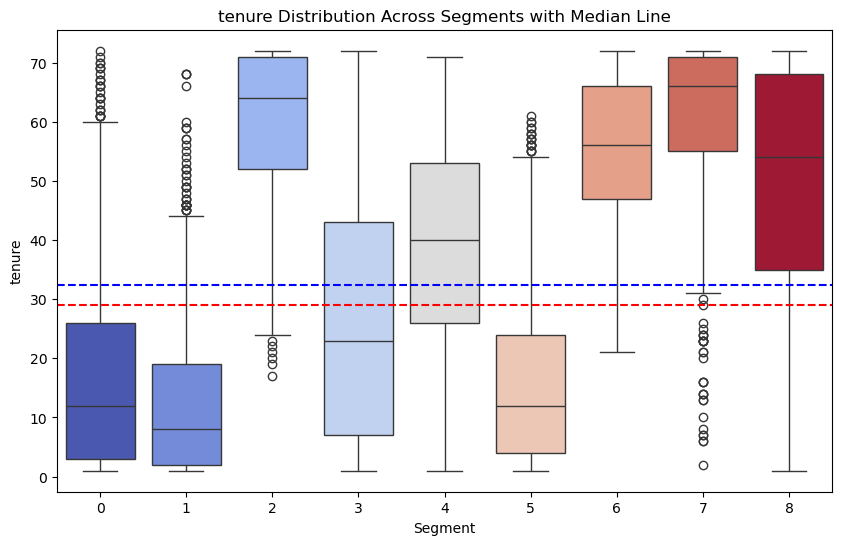

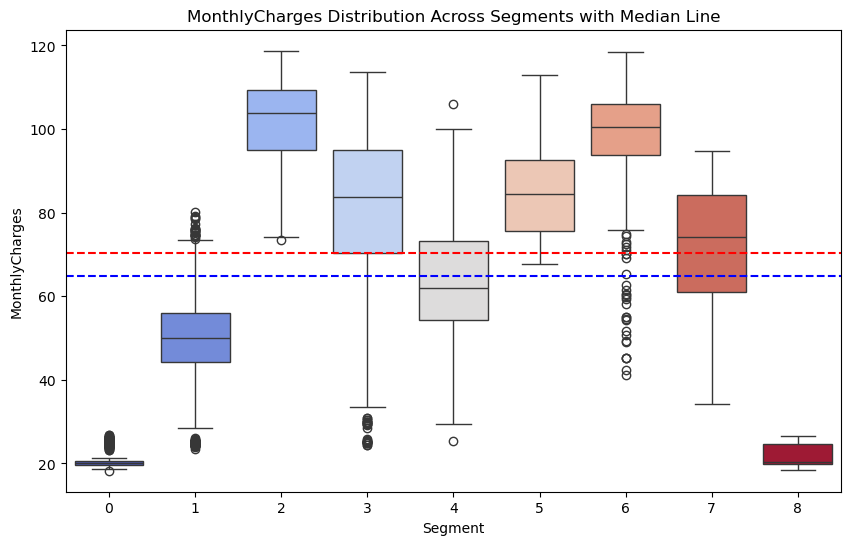

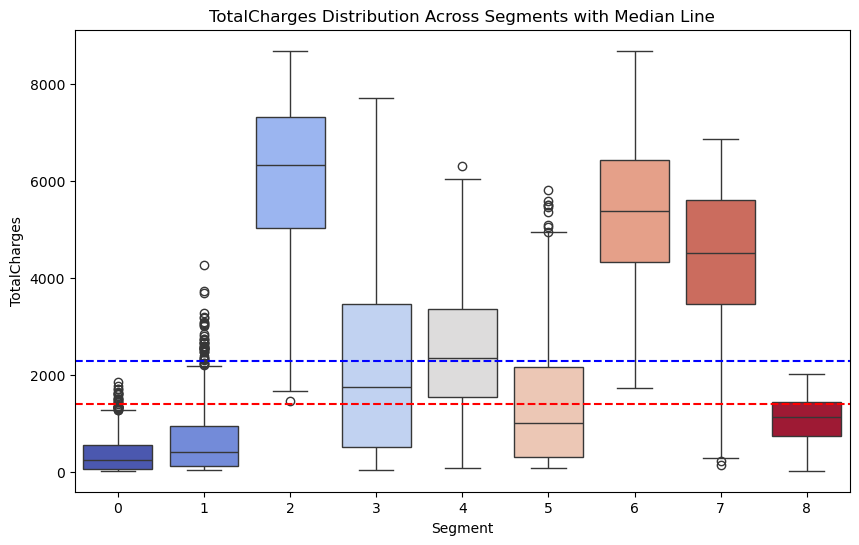

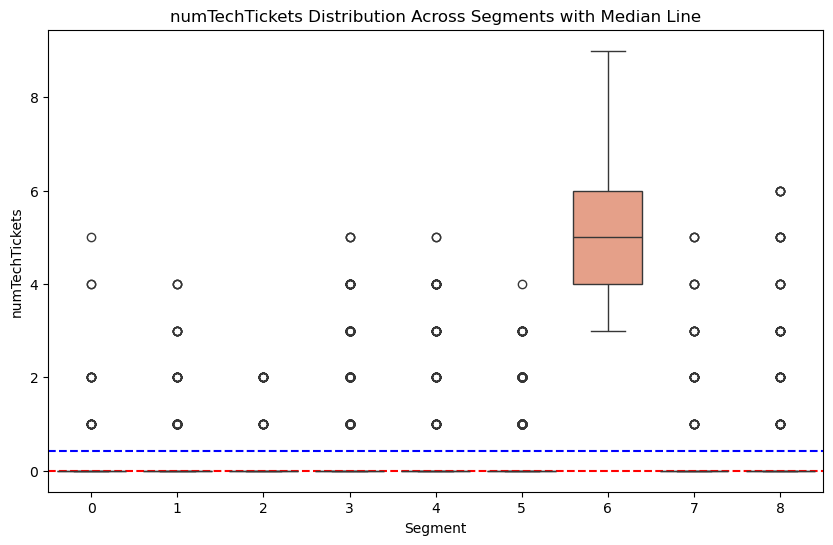

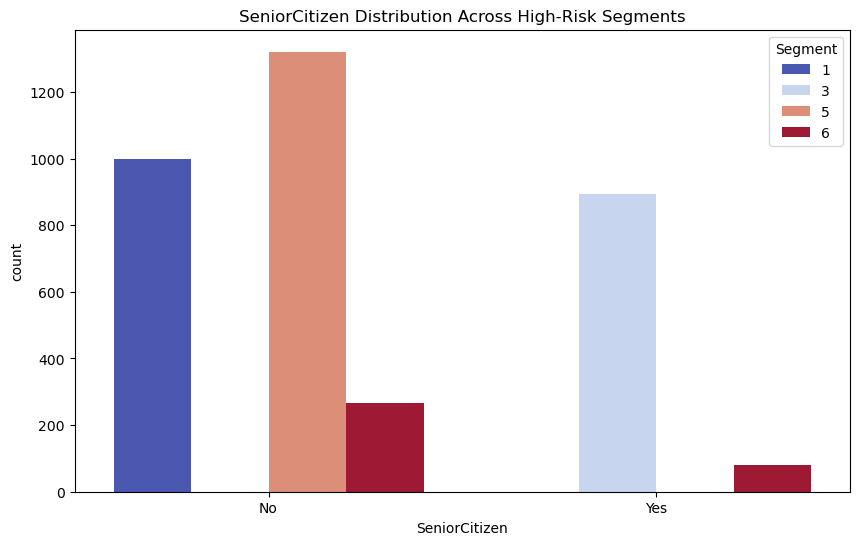

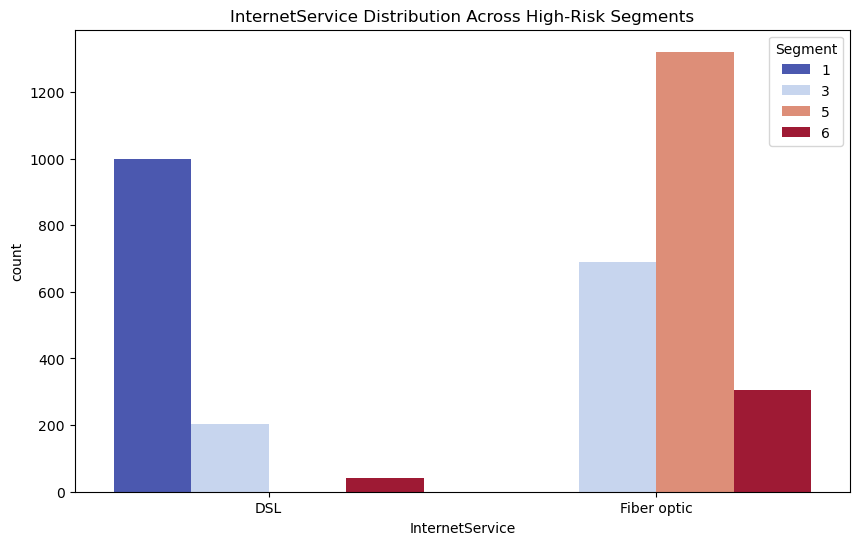

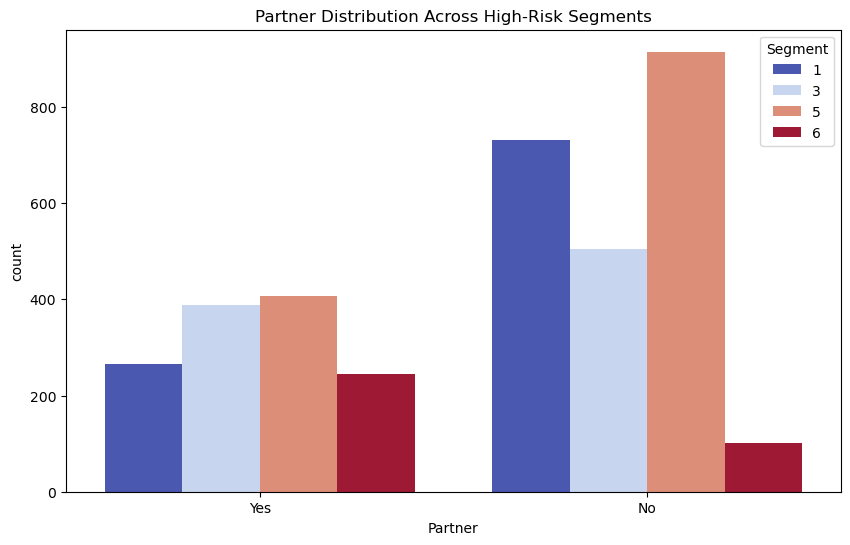

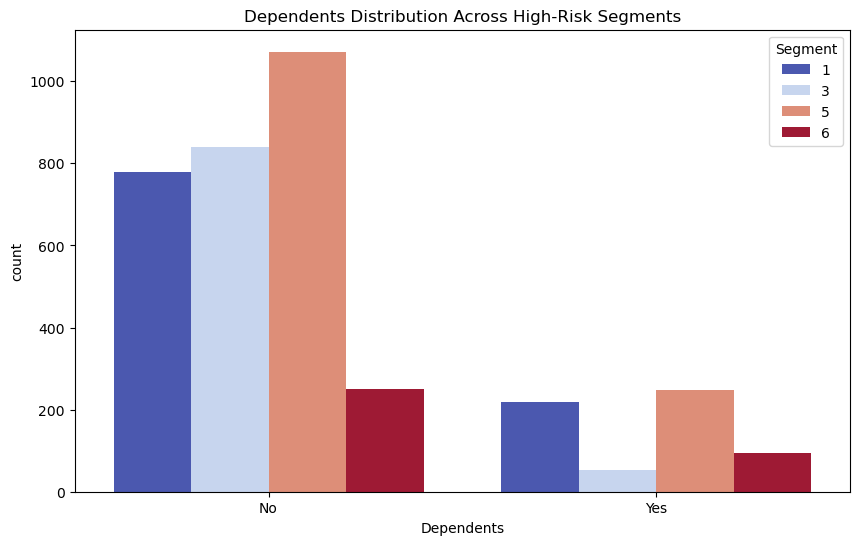

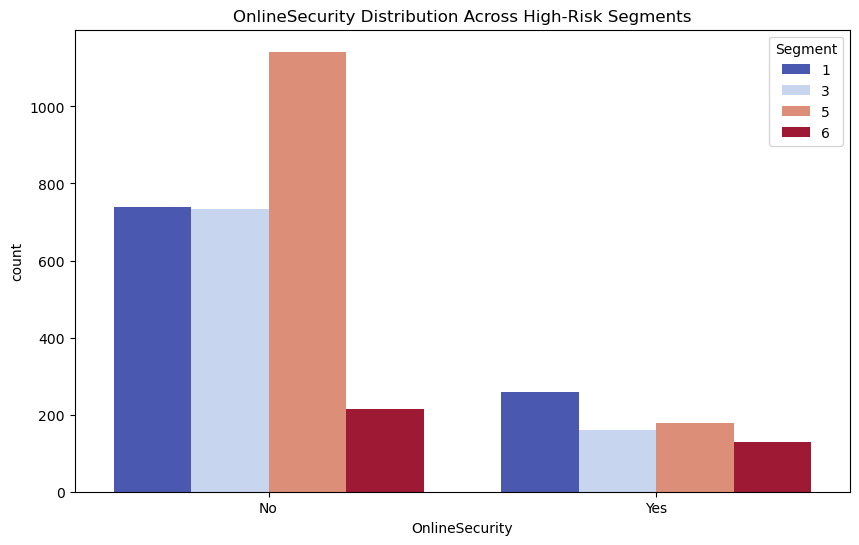

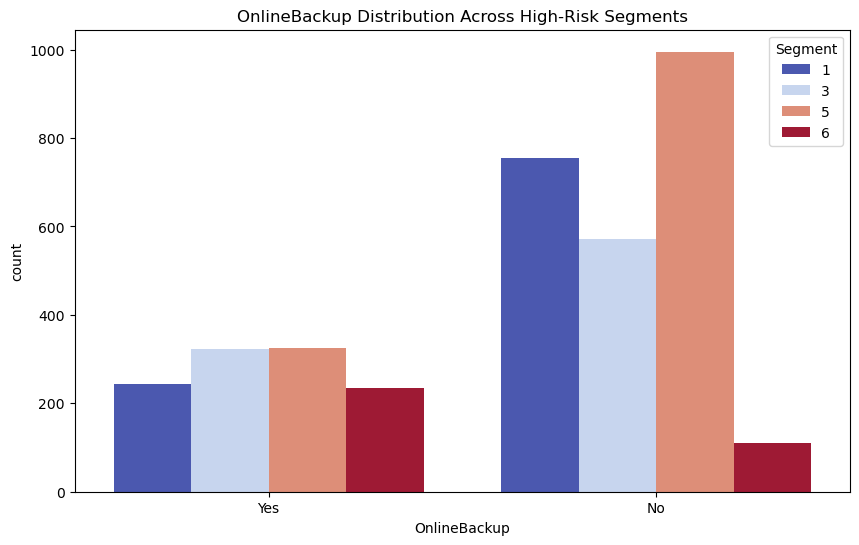

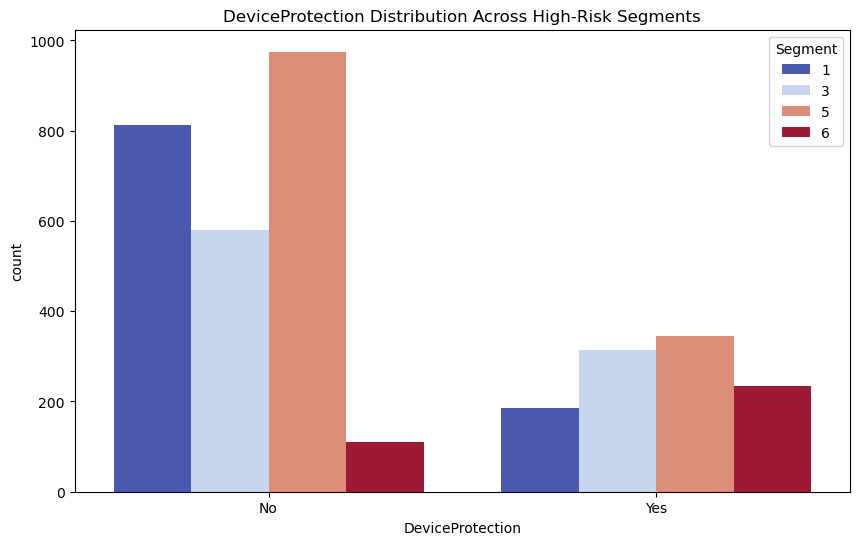

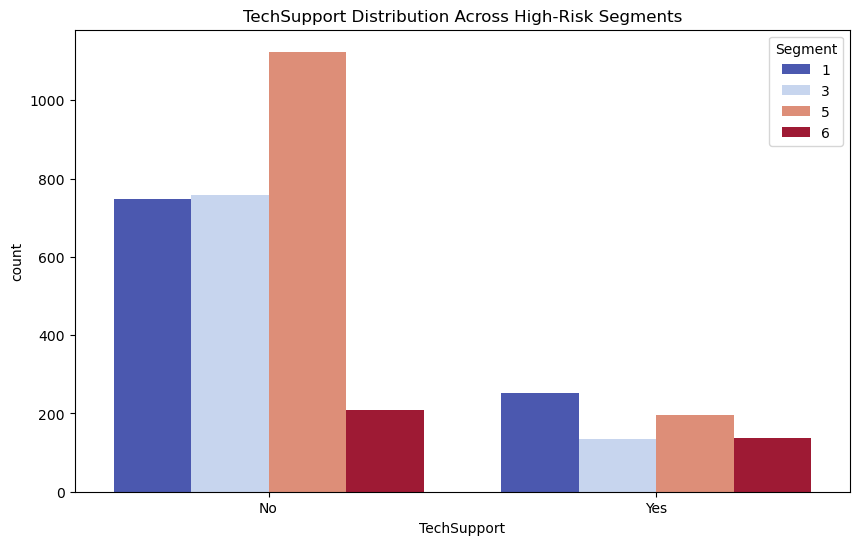

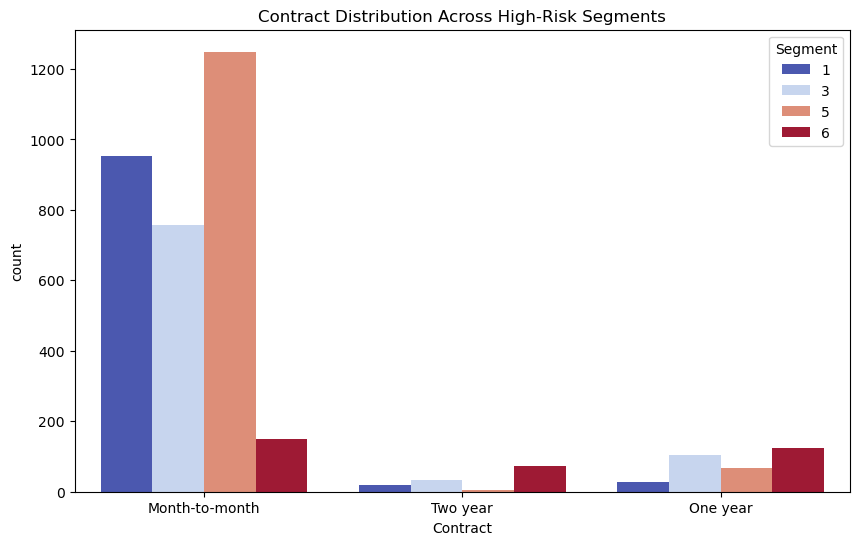

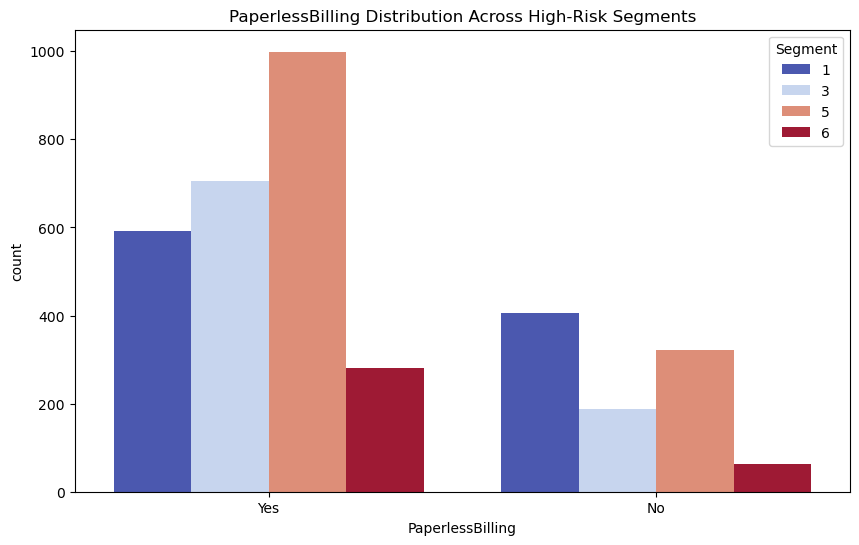

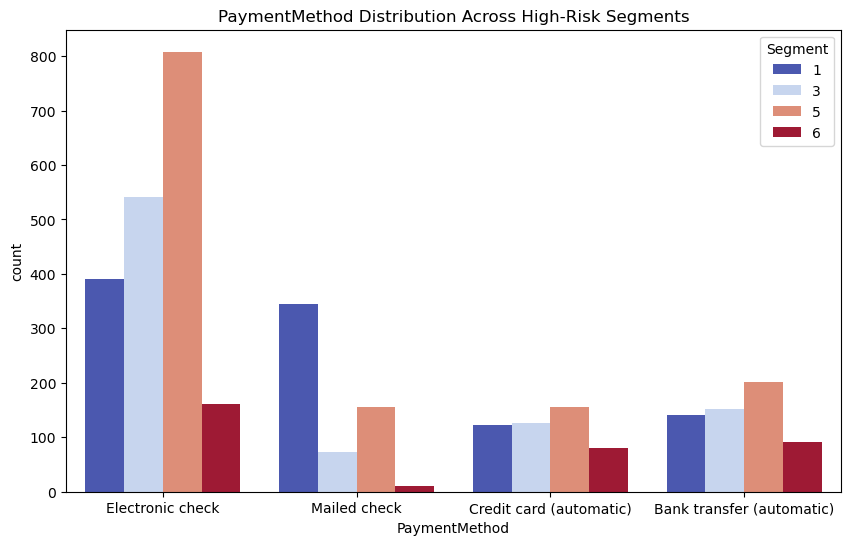

In [33]:
all_segments = [0, 1,2,3, 4,5,6, 7, 8] 

# Plot the distribution of key numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'numTechTickets']
# Plot the distribution of key numerical features with median line
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(x='Segment', hue='Segment', y=feature, data=df[df['Segment'].isin(all_segments)], palette='coolwarm', legend=False)
    
    # Calculate median value
    median = df[feature].median()
    mean = df[feature].mean()
    
    # Add horizontal line at the median
    ax.axhline(median, color='red', linestyle='--', label=f'Median: {median:.2f}')
    ax.axhline(mean, color='blue', linestyle='--', label=f'Mean: {median:.2f}')
    
    plt.title(f'{feature} Distribution Across Segments with Median Line')
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
    plt.show()
    
high_risk_segments = [1,3, 5, 6]
# Plot the distribution of key categorical features
categorical_features = ['SeniorCitizen', 'InternetService', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='Segment', data=df[df['Segment'].isin(high_risk_segments)], palette='coolwarm')
    plt.title(f'{feature} Distribution Across High-Risk Segments')
    plt.show()



We used means and median values in the numerical plots to identify central values and check where our high-risk groups are.

## 6) Correlations

Check for **correlations**:

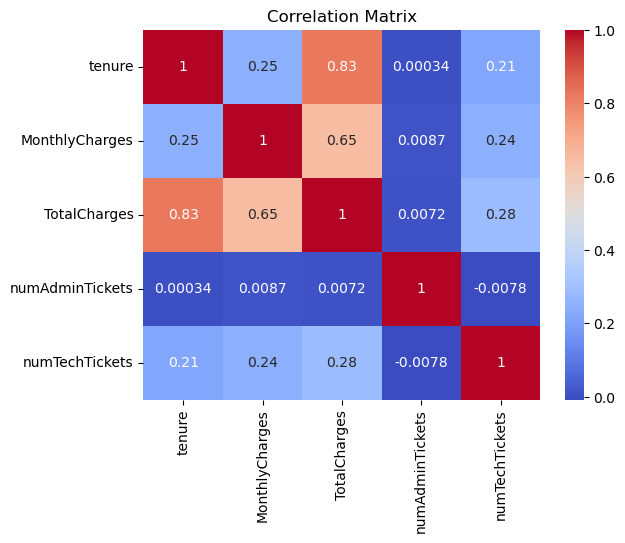

           Feature       VIF
0           tenure  6.421804
1   MonthlyCharges  3.544093
2     TotalCharges  8.318883
3  numAdminTickets  1.150800
4   numTechTickets  1.216856


In [37]:
# Correlation matrix for numerical variables
corr_matrix = df[numerical_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Calculate VIF to check multicollinearity
X = df[numerical_vars]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


We see **tenure and Total charges** have a strong correlation and multicollinearity (VIF). This means that we could group them together as one (specially if we continue developing a model).

## 7) Interpretation and recommendations

### **Key Conclusions**

These insights and recommendations provide a strategic approach to reduce churn by addressing the specific needs and pain points of at-risk customer segments.

1. **Demographics and Household Structure:**
   - **Senior Citizens** exhibit a **higher proportion of churn** compared to other age groups, likely due to challenges with service complexity.
   - Customers with **no partner or dependents** have **higher churn**, possibly due to less attachment to the service. <p> </p>

2. **Service and Product Offerings:**
   - **DSL** and especially **Fiber optic users** have a **higher churn rate** than customers without internet service, suggesting higher expectations or service dissatisfaction.
   - **Lack of support services** (e.g., no online backup, device protection) correlates with **increased churn**, indicating that these customers feel less supported. <p> </p>

3. **Contract and Billing Preferences:**
   - **Month-to-month contracts** are strongly associated with **higher churn**, reflecting the flexibility to switch providers easily.
   - **Paperless billing** is linked to **higher churn**, potentially due to perceived impersonality or disengagement. <p> </p>

4. **Financial Factors:**
   - **Shorter tenure** is associated with **higher churn**, although this may partly reflect the natural aging of the customer base.
   - **Higher monthly charges** correlate with **higher churn**, indicating potential dissatisfaction with perceived value. <p> </p>

### **High-Risk Customer Profiles**

1. **Profile 1** (Cluster 1):
   - **Low tenure**, **low monthly charges**, **DSL user**, **no support services**, **month-to-month contract**.
   - **Insight:** Low engagement and commitment, at high risk of churn. <p> </p>

2. **Profile 2** (Cluster 3):
   - **Average tenure**, **higher charges**, **senior citizen**, **fiber optic user**, **no support services**, **month-to-month contract**.
   - **Insight:** Seniors paying more but not feeling valued; high churn potential. <p> </p>

3. **Profile 3** (Cluster 5):
   - **Low tenure**, **high charges**, **fiber optic user**, **no support services**, **month-to-month contract**.
   - **Insight:** Quick churn likely due to early dissatisfaction. <p> </p>

4. **Profile 4** (Cluster 6):
   - **High tenure**, **high charges**, **many tech tickets**, **fiber optic user**, **has support services**.
   - **Insight:** Long-term customers frustrated by technical issues; risk of churn despite loyalty. <p> </p>

### **Recommendations**

1. **Targeted Retention Programs:**
   - **Senior Citizens:** Offer tailored support services, including simplified interfaces and personalized customer care.
   - **Single Customers:** Increase engagement through personalized offers and loyalty programs. <p> </p>

2. **Service Quality Improvement:**
   - **Internet Users:** Enhance service reliability and proactively address issues.
   - **Support Services Upsell:** Offer bundled discounts or trials for essential support services. <p> </p>

3. **Contract Strategy:**
   - **Month-to-Month Contracts:** Incentivize transitions to longer-term contracts with discounts or added benefits. <p> </p>

4. **Billing and Engagement Enhancements:**
   - **Paperless Billing:** Improve engagement with customers using paperless billing, possibly by integrating rewards or personalized updates.
   - **High Charges:** Provide additional value through exclusive offers and premium support to justify higher costs. <p> </p>

5. **Proactive Issue Resolution:**
   - **High Tech Tickets:** Prioritize support and offer proactive service checks for customers with frequent technical issues.


## Bonus: Dashboard using Dash

In [42]:
# Generate key statistics
churn_rate = df['Churn'].value_counts(normalize=True).get('Yes') * 100
total_customers = df['customerID'].nunique()
senior_citizen_churn_rate = df[df['SeniorCitizen'] == 'Yes']['Churn'].value_counts(normalize=True).get('Yes') * 100

# Custom colors for churn plots
churn_colors = {'Yes': 'orange', 'No': 'green'}

# Dropdown options
gender_options = [{'label': gender, 'value': gender} for gender in df['gender'].unique()]
payment_method_options = [{'label': method, 'value': method} for method in df['PaymentMethod'].unique()]

# Filtering based on dropdowns
def filter_data(gender, payment_method):
    filtered_df = df.copy()
    if gender:
        filtered_df = filtered_df[filtered_df['gender'] == gender]
    if payment_method:
        filtered_df = filtered_df[filtered_df['PaymentMethod'] == payment_method]
    return filtered_df

# App layout
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H1("Telco Company Customer Churn Dashboard"), width=12)
    ]),

    # Dropdown filters
    dbc.Row([
        dbc.Col([
            dbc.Label("Select Gender"),
            dcc.Dropdown(id='gender-dropdown', options=gender_options, placeholder="All Genders")
        ], width=6),

        dbc.Col([
            dbc.Label("Select Payment Method"),
            dcc.Dropdown(id='payment-dropdown', options=payment_method_options, placeholder="All Payment Methods")
        ], width=6)
    ], className="mb-4"),

    # Key Statistics Cards
    dbc.Row([
        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H5("Total Customers", className="card-title"),
                html.P(f"{total_customers}", className="card-text"),
            ])
        ], color="primary", inverse=True), width=4),

        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H5("Overall Churn Rate", className="card-title"),
                html.P(f"{churn_rate:.2f}%", className="card-text"),
            ])
        ], color="warning", inverse=True), width=4),

        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H5("Senior Citizen Churn Rate", className="card-title"),
                html.P(f"{senior_citizen_churn_rate:.2f}%", className="card-text"),
            ])
        ], color="danger", inverse=True), width=4)
    ], className="mb-4"),

    # Visualizations
    dbc.Row([
        dbc.Col(dcc.Graph(id='churn-overview'), width=4),
        dbc.Col(dcc.Graph(id='churn-by-senior'), width=8)
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='churn-by-contract'), width=6),
        dbc.Col(dcc.Graph(id='churn-by-internet'), width=6)
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='churn-by-tenure'), width=6),
        dbc.Col(dcc.Graph(id='churn-by-charges'), width=6)
    ]),

    # High-Risk Customer Profiles
    dbc.Row([
        dbc.Col(html.H2("High-Risk Customer Profiles"), width=12)
    ]),
    dbc.Row([
        dbc.Col(html.P([ html.Strong("Type 1:"), " Low tenure, low monthly charges, DSL user, no support services, month-to-month contract. High risk of churn."]), width=12),
        dbc.Col(html.P([ html.Strong("Type 2:")," Average tenure, higher charges, senior citizen, fiber optic user, no support services, month-to-month contract. High churn potential."]), width=12),
        dbc.Col(html.P([ html.Strong("Type 3:")," Low tenure, high charges, fiber optic user, no support services, month-to-month contract. Likely to churn early."]), width=12),
        dbc.Col(html.P([ html.Strong("Type 4:")," High tenure, high charges, many tech tickets, fiber optic user, has support services. Risk of churn despite loyalty."]), width=12)
    ]),

    # Recommendations
    dbc.Row([
        dbc.Col(html.H2("Recommendations"), width=12)
    ]),
    dbc.Row([
        dbc.Col(html.Ul([
            html.Li([html.Strong("Targeted Retention Programs:"), " Develop specific retention strategies for senior citizens and single customers."]),
            html.Li([html.Strong("Service Quality Improvement:"), " Enhance reliability and proactively address service issues, especially for internet users."]),
            html.Li([html.Strong("Contract Strategy:"), " Encourage customers on month-to-month contracts to switch to longer-term contracts with incentives."]),
            html.Li([html.Strong("Billing and Engagement Enhancements:"), " Improve engagement for customers using paperless billing, potentially adding rewards."]),
            html.Li([html.Strong("Proactive Issue Resolution:"), " Offer priority support for customers with frequent technical issues to prevent churn."]),
        ]), width=12)
    ])
], fluid=True)

# Update graphs based on selected filters
@app.callback(
    [dash.dependencies.Output('churn-overview', 'figure'),
     dash.dependencies.Output('churn-by-senior', 'figure'),
     dash.dependencies.Output('churn-by-contract', 'figure'),
     dash.dependencies.Output('churn-by-internet', 'figure'),
     dash.dependencies.Output('churn-by-tenure', 'figure'),
     dash.dependencies.Output('churn-by-charges', 'figure')],
    [dash.dependencies.Input('gender-dropdown', 'value'),
     dash.dependencies.Input('payment-dropdown', 'value')]
)
def update_graphs(selected_gender, selected_payment_method):
    filtered_df = filter_data(selected_gender, selected_payment_method)

    # Visualizations
    fig_churn_overview = px.pie(filtered_df, names='Churn', title='Overall Churn Rate', color='Churn', color_discrete_map=churn_colors)
    fig_churn_by_senior = px.bar(filtered_df.groupby(['SeniorCitizen', 'Churn']).size().reset_index(name='Count'),
                                 x='SeniorCitizen', y='Count', color='Churn',
                                 title='Churn by Senior Citizen Status',
                                 labels={'SeniorCitizen': 'Senior Citizen', 'Count': 'Customer Count'},
                                 barmode='group', color_discrete_map=churn_colors)
    fig_churn_by_contract = px.bar(filtered_df.groupby(['Contract', 'Churn']).size().reset_index(name='Count'),
                                   x='Contract', y='Count', color='Churn',
                                   title='Churn by Contract Type',
                                   labels={'Contract': 'Contract Type', 'Count': 'Customer Count'},
                                   barmode='group', color_discrete_map=churn_colors)
    fig_churn_by_internet = px.bar(filtered_df.groupby(['InternetService', 'Churn']).size().reset_index(name='Count'),
                                   x='InternetService', y='Count', color='Churn',
                                   title='Churn by Internet Service Type',
                                   labels={'InternetService': 'Internet Service Type', 'Count': 'Customer Count'},
                                   barmode='group', color_discrete_map=churn_colors)
    fig_churn_by_tenure = px.box(filtered_df, x='Churn', y='tenure', color='Churn', 
                                 title='Distribution of Tenure by Churn',
                                 labels={'tenure': 'Tenure (Months)', 'Churn': 'Churn'},
                                 color_discrete_map=churn_colors, points="all")
    fig_churn_by_charges = px.scatter(filtered_df, x='MonthlyCharges', y='TotalCharges', color='Churn',
                                      title='Monthly Charges vs. Total Charges by Churn',
                                      labels={'MonthlyCharges': 'Monthly Charges', 'TotalCharges': 'Total Charges'},
                                      color_discrete_map=churn_colors)

    return fig_churn_overview, fig_churn_by_senior, fig_churn_by_contract, fig_churn_by_internet, fig_churn_by_tenure, fig_churn_by_charges

if __name__ == '__main__':
    app.run_server(debug=True)